In [1]:
from Architectures.VAE import VAE
from Data.load import load
from matplotlib import pyplot as plt
import numpy as np

In [2]:
train, test = load("Pre-processed/CN", take=-1)

Loading CN: 100%|██████████| 338/338 [02:20<00:00,  2.41it/s]


In [3]:
latent_dim = 128
vae = VAE(train.shape,halvings=3,init_hidden_depth=12, latent_dim=latent_dim, output_activation="tanh",lambda_=1e-5)
vae.compile(loss="mse",optimizer="adam")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 10, 12, 10, 48)



-1.6031043466338535 1.0651056874958054


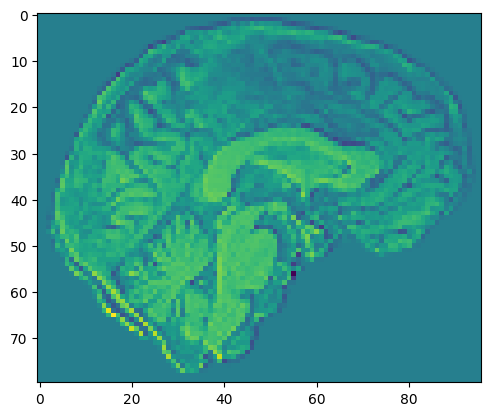

In [50]:
# Train on the diff to the mean brain instead
from Filters.filters import edge_detect
# mean_brain = np.mean(train, axis=0)
diff_train = edge_detect(train,alpha=0.6) # train - mean_brain
diff_test = edge_detect(test,alpha=0.6) # test - mean_brain
plt.imshow(np.rot90(diff_train[0][40]))
print(np.min(diff_train), np.max(diff_train))

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the sampling function for the reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        mu, logvar = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mu + tf.exp(0.5 * logvar) * epsilon

# Define the VAE model
class VAE(keras.Model):
    def __init__(
            self,
            input_shape,
            halvings=4,
            init_hidden_depth=8,
            latent_dim=1_000,
            output_activation="tanh",
            lambda_=1e-5,
            hidden_activation=activations.leaky_relu
            ):
        super(VAE, self).__init__()
        self.lambda_ = lambda_

        shape_changed=False
        if input_shape[-1]>3:
            input_shape = list(input_shape) + [1]
            shape_changed=True
        if len(input_shape)>4:
            input_shape = input_shape[-4:]
            shape_changed=True
        if shape_changed: print(f"Interpreted image shape: {tuple(input_shape)}")

        # Encoder
        encoder_input = x = layers.Input(shape=input_shape)
        depth = init_hidden_depth
        for _ in range(halvings):
            x = layers.Conv3D(depth, (3, 3, 3), strides=2, activation=hidden_activation, padding="same")(x)
            x = layers.Dropout(0.05)(x)
            depth <<= 1

        pre_flatten_shape = x.shape
        print(f"Pre-flattened latent shape: {pre_flatten_shape}")
        x = layers.Flatten()(x)
        
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        
        self.encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

        # Decoder
        decoder_input = layers.Input(shape=(latent_dim,))
        x = layers.Dense(pre_flatten_shape[1] * pre_flatten_shape[2] * pre_flatten_shape[3] * pre_flatten_shape[4], activation="relu")(decoder_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        
        for _ in range(halvings):
            depth >>= 1
            x = layers.Conv3D(depth, (3, 3, 3), activation=hidden_activation, padding="same")(x)
            x = layers.UpSampling3D((2, 2, 2))(x)
        decoded = layers.Conv3D(1, (3, 3, 3), activation=output_activation, padding="same")(x)
        self.decoder = Model(decoder_input, decoded, name="decoder")
        
    def call(self, inputs):
        z, mu, logvar = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar))*self.lambda_
        self.add_loss(kl_loss)
        return reconstructed
    
    
    def save(self, path):
        """Save the VAE model, encoder, and decoder to disk."""
        os.makedirs(path, exist_ok=True)
        self.encoder.save(os.path.join(path, "encoder.keras"))
        self.decoder.save(os.path.join(path, "decoder.keras"))
        print(f"Models saved to {path}")
    
    @staticmethod
    def open(path):
        """Load the VAE model, encoder, and decoder from disk."""
        encoder = tf.keras.models.load_model(os.path.join(path, "encoder.keras"), custom_objects={'Sampling': Sampling})
        decoder = tf.keras.models.load_model(os.path.join(path, "decoder.keras"))
        
        # Create an instance of VAE without initializing models
        vae = VAE.__new__(VAE)
        vae.encoder = encoder
        vae.decoder = decoder
        
        print("Models loaded successfully.")
        return vae

# Instantiate the VAE model
latent_dim = 35
vae = VAE(train.shape,latent_dim=latent_dim,halvings=4, init_hidden_depth=20, lambda_=1e-5)
vae.compile(optimizer=keras.optimizers.Adam(), loss="mse")

Interpreted image shape: (80, 96, 80, 1)
Pre-flattened latent shape: (None, 5, 6, 5, 160)


In [53]:
vae.fit(train, diff_train, epochs=3, batch_size=32, verbose=True)
vae.fit(train, train, epochs=20, batch_size=32, verbose=True)
vae.save(f"Trained Models/VAE/diff_{latent_dim}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - loss: 0.0260
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 0.0247
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0155
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0127
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0113
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0099
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0094
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0091
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0088
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.0085
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0085
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - loss: 0.0082
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.0082
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.0081
Epoch 14/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - loss: 0.0080
Epoch 15/20
10/10 ━━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


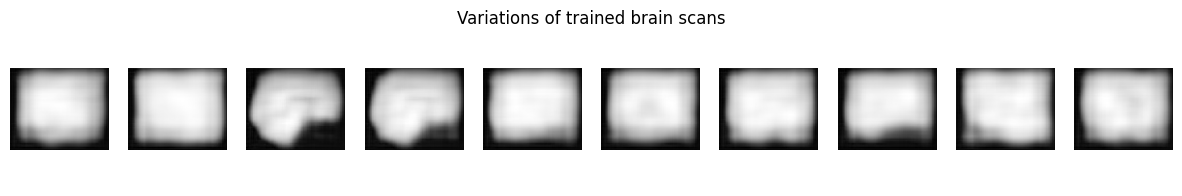

In [54]:
num_samples = 10
random_latent_vectors = np.random.normal(size=(num_samples, latent_dim))
generated_images = vae.decoder.predict(random_latent_vectors)

plt.figure(figsize=(15, 2))
plt.title("Variations of trained brain scans")
plt.axis("off")
for i in range(num_samples):
    ax = plt.subplot(1, num_samples, i + 1)
    plt.imshow(np.rot90(generated_images[i,40,:,:]), cmap="gray")
    ax.axis("off")
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step


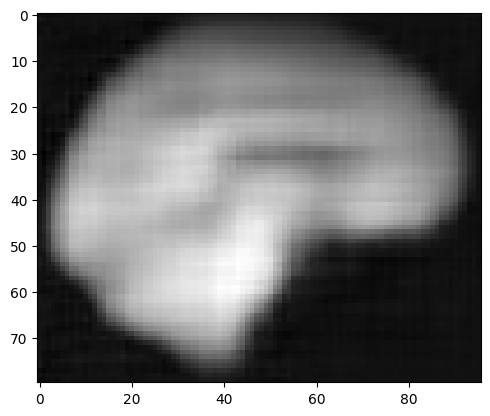

In [56]:
z_mean, z_std, z = vae.encoder.predict(test)
recon = vae.decoder.predict(z_mean)
plt.imshow(np.rot90(recon[0][40]),cmap="gray")

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step


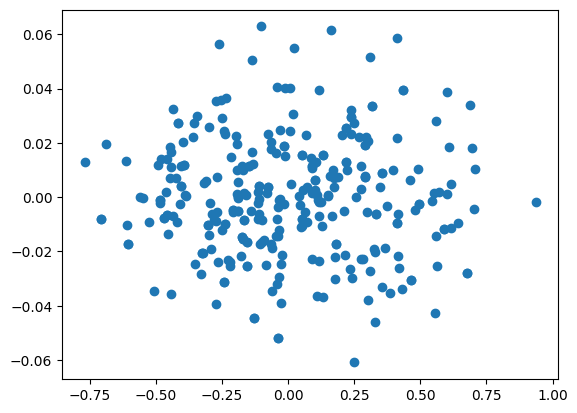

In [57]:
z_mean, z_std, z = vae.encoder.predict(train)
from sklearn.decomposition import PCA
pca = PCA(2)
points = pca.fit_transform(z_mean)
plt.scatter(points[:,0],points[:,1])

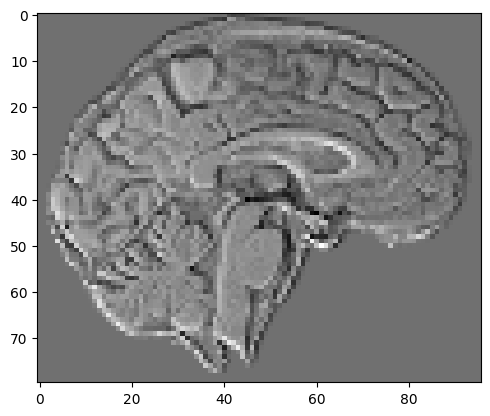

In [40]:
plt.imshow(np.rot90(diff_test[0][40].reshape((96,80))),cmap="gray") # mean_brain[40]+

In [59]:
from Metrics.metrics import NMSE, SSIM
SSIM(recon.reshape(test.shape), test)

0.6676104673738039